In [ ]:
# ✅ Cell 1: Install Dependencies & Enable GPU
!pip install torch torchvision matplotlib tqdm scikit-learn pandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import json
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

# Set paths to save model checkpoints in Google Drive
drive_root = "/content/drive/MyDrive/distillation_project_files/"
os.makedirs(drive_root, exist_ok=True)

# Set dynamic paths based on method
method_name = "selective_hinting"
student_path     = os.path.join(drive_root, f"student_{method_name}.pth")
teacher_path     = os.path.join(drive_root, "teacher_cifar10_finetuned.pth")
projections_path = os.path.join(drive_root, f"proj_layers_{method_name}.pth")
checkpoint_path  = os.path.join(drive_root, f"checkpoint_{method_name}.json")
log_path         = os.path.join(drive_root, f"training_log_{method_name}.csv")


Using device: cpu
Mounted at /content/drive


In [ ]:
# ✅ Cell 3: Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
sample_img, _ = train_data[0]

100%|██████████| 170M/170M [00:02<00:00, 79.3MB/s]


In [ ]:
# ✅ Cell 4: Load Teacher Model
teacher = models.resnet18()
teacher.fc = nn.Linear(512, 10)
if os.path.exists(teacher_path):
    teacher.load_state_dict(torch.load(teacher_path, map_location=device))
    print("✅ Loaded pre-trained teacher.")
else:
    print("🚀 No saved teacher, training from ImageNet weights...")
    teacher = models.resnet18(pretrained=True)
    teacher.fc = nn.Linear(512, 10)
    teacher = teacher.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=1e-3)

    teacher.train()
    for epoch in range(7):
        correct, total = 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Teacher Epoch {epoch+1}"):
            imgs, labels = imgs.to(device), labels.to(device)
            out = teacher(imgs)
            loss = criterion(out, labels)

            optimizer_teacher.zero_grad()
            loss.backward()
            optimizer_teacher.step()

            correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"[Teacher Finetune] Epoch {epoch+1} | Accuracy: {acc:.2f}%")

    torch.save(teacher.state_dict(), teacher_path)

teacher = teacher.to(device)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# Register hooks
hooked_tensors = {}
def hook_fn(name):
    def _hook(module, inp, out):
        hooked_tensors[name] = out.detach()
    return _hook

teacher.layer1[1].register_forward_hook(hook_fn("t1"))
teacher.layer2[1].register_forward_hook(hook_fn("t2"))
teacher.layer3[1].register_forward_hook(hook_fn("t3"))
teacher.layer4[1].register_forward_hook(hook_fn("t4"))


✅ Loaded pre-trained teacher.


In [ ]:
"""
    Select the teacher layers whose activations are the most 'information-rich'
    according to simple activation variance.

    Assumptions / prerequisites:
      • Forward hooks have already been registered on the teacher, and they write
        activations into the global dict hooked_tensors with keys like "t1","t2","t3",...
      • sample_img is a single preprocessed CIFAR-10 image tensor with shape [C, H, W].
      • device is set (cuda/cpu) and matches the teacher's device.

    Args:
        model (nn.Module): Teacher network with hooks already attached.
        sample_img (Tensor): One image [C, H, W] used to probe activations.
        top_k (int): How many highest-variance layers to keep.

    Returns:
        List[str]: The hook keys of the top-K layers sorted by descending variance.
    """
def compute_top_variance_teacher_layers(model, sample_img, top_k=3):
    model.eval()
    with torch.no_grad():
        _ = model(sample_img.unsqueeze(0).to(device))  # Trigger forward pass

    variances = {}
    for key, tensor in hooked_tensors.items():
        var = tensor.var().item()
        variances[key] = var

    # Sort keys by variance descending
    sorted_keys = sorted(variances, key=lambda k: variances[k], reverse=True)
    top_keys = sorted_keys[:top_k]
    print(f"🔍 Top-{top_k} variance layers: {top_keys}")
    return top_keys

# Compute selected hint keys dynamically (used for selective hinting)
selected_hint_keys = compute_top_variance_teacher_layers(teacher, sample_img, top_k=3)


🔍 Top-3 variance layers: ['t4', 't1', 't2']


In [ ]:
"""
    A tiny 5-layer CNN used as the student.
    - Each conv is followed by ReLU.
    - Stride-2 on layers 2–5 progressively downsamples H×W.
    - Final features are global-averaged and fed to a linear classifier.
    - During forward() we also expose intermediate activations as
      { "s1": ..., "s2": ..., "s3": ..., "s4": ..., "s5": ... } for hint loss.
    """
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.ModuleList([
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.Conv2d(512, 512, 3, stride=2, padding=1),
        ])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        feats = {}
        for i, layer in enumerate(self.features):
            x = F.relu(layer(x))
            feats[f"s{i+1}"] = x
        pooled = self.pool(x).squeeze(-1).squeeze(-1)
        logits = self.classifier(pooled)
        return logits, feats

      """
    1×1 projection convs that map student feature channels to the
    teacher channels for the selected hint layers.

    Inputs:
      selected_indices: list like ["t1","t3","t4"] coming from your variance
                        selector. We assume student layers are s1..s5 and
                        teacher hooks are t1..t4.

    Notes:
      - Channel map must match your teacher: here we assume ResNet-18/34
        stage outputs: {t1:64, t2:128, t3:256, t4:512}.
      - We index the corresponding student layer as s{int(k[1])}.
        (Safe here because keys are t1..t4; if you ever use t10, parse with k[1:].)
    """

class ProjectionLayers(nn.Module):
    def __init__(self, selected_indices):
        super().__init__()
        student_channels = [64, 128, 256, 512, 512]
        teacher_channels = {"t1": 64, "t2": 128, "t3": 256, "t4": 512}
        self.selected_keys = selected_indices
        self.proj = nn.ModuleList([
            nn.Conv2d(student_channels[int(k[1])-1], teacher_channels[k], kernel_size=1)
            for k in selected_indices
        ])

    def forward(self, student_feats):
        return [
            proj(student_feats[f"s{int(k[1])}"])
            for proj, k in zip(self.proj, self.selected_keys)
        ]

student = StudentCNN().to(device)
projections = ProjectionLayers(selected_hint_keys).to(device)

if os.path.exists(student_path):
    print("✅ Found saved student model, loading...")
    student.load_state_dict(torch.load(student_path, map_location=device))
    projections.load_state_dict(torch.load(projections_path, map_location=device))
else:
    print("🚀 No saved student, will train from scratch...")

🚀 No saved student, will train from scratch...


In [ ]:
"""
    Train a student model under different regimes (baseline KD+CE, static-β hint warm-up,
    or adaptive-β with hints), optionally using a selective set of teacher layers.

    Args:
        method (str):
            - "baseline" → KD + CE from the start (no hint-only phase).
            - any other label → use hint loss; exact behavior controlled by use_adaptive_beta.
        use_adaptive_beta (bool):
            - False → "static-β warm-up": optimize only hint loss for the first E1 epochs,
              then keep β fixed and add KD + CE afterward.
            - True  → same warm-up, but *halve β* whenever KD-loss plateaus (patience built-in).
        selective_layers (List[str] or None):
            - Keys of teacher hooks to match (e.g., ["t1","t3","t4"]).
            - Must not be None when using hints, because we iterate over this list for hint loss.

    Returns:
        pd.DataFrame: training history with per-epoch metrics (losses, accuracy, β, method).
    """
def train(method="baseline", use_adaptive_beta=False, selective_layers=None):
    student = StudentCNN().to(device)
    projections = ProjectionLayers(selective_layers).to(device)

    optimizer = torch.optim.Adam(list(student.parameters()) + list(projections.parameters()), lr=1e-3)
    T = 4.0
    alpha, gamma = 1.0, 1.0
    E1, E2 = 5, 20
    beta = 250.0
    best_kd_loss = float('inf')
    no_kd_improve_epochs = 0
    beta_decay_count = 0
    max_beta_decays = 3
    start_epoch = 0
    history = []

    # Define checkpoint path
    checkpoint_path = os.path.join(drive_root, f"checkpoint_{method}.pth")

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print(f"✅ Found checkpoint for {method}, loading...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        student.load_state_dict(checkpoint['student_state_dict'])
        projections.load_state_dict(checkpoint['projections_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_kd_loss = checkpoint['best_kd_loss']
        no_kd_improve_epochs = checkpoint['no_kd_improve_epochs']
        beta_decay_count = checkpoint['beta_decay_count']
        beta = checkpoint['beta']
        print(f"Resuming training from epoch {start_epoch}")

    print(f"\n🚀 Starting training | Method: {method} | Selective layers: {selective_layers}\n")

    for epoch in range(start_epoch, E2):
        student.train()
        total_loss, total_correct, total_kd_loss, total_hint_loss = 0, 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"[{method.upper()}] Epoch {epoch+1}/{E2}"):
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                _ = teacher(images)

            logits_s, student_feats = student(images)
            proj_feats = projections(student_feats)

            # Compute Hint Loss
            hint_loss = 0
            for i, key in enumerate(selective_layers):
                t_feat = hooked_tensors[key]
                s_feat = proj_feats[i]
                if s_feat.shape[-2:] != t_feat.shape[-2:]:
                    t_feat = F.interpolate(t_feat, size=s_feat.shape[-2:], mode='bilinear', align_corners=False)
                hint_loss += F.mse_loss(s_feat, t_feat)

            # KD + CE loss
            logits_t = teacher(images)
            kd_loss = F.kl_div(
                F.log_softmax(logits_s / T, dim=1),
                F.softmax(logits_t / T, dim=1),
                reduction='batchmean'
            ) * (T ** 2)

            ce_loss = F.cross_entropy(logits_s, labels)

            if method == "baseline":
                loss = alpha * kd_loss + gamma * ce_loss
            elif method == "baseline_hint_loss" and epoch < E1:
                loss = beta * hint_loss
            elif method == "baseline_hint_loss" and epoch >= E1:
                loss = alpha * kd_loss + gamma * ce_loss + beta * hint_loss
            elif not use_adaptive_beta or epoch < E1:
                loss = beta * hint_loss
            else:
                loss = alpha * kd_loss + gamma * ce_loss + beta * hint_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (logits_s.argmax(1) == labels).sum().item()
            total_kd_loss += kd_loss.item()
            total_hint_loss += hint_loss.item()

        acc = total_correct / len(train_loader.dataset) * 100
        avg_kd = total_kd_loss / len(train_loader)
        avg_hint = total_hint_loss / len(train_loader)

        history.append({
            "epoch": epoch + 1,
            "loss": total_loss,
            "accuracy": acc,
            "avg_kd_loss": avg_kd,
            "avg_hint_loss": avg_hint,
            "beta": beta,
            "method": method
        })

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'student_state_dict': student.state_dict(),
            'projections_state_dict': projections.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_kd_loss': best_kd_loss,
            'no_kd_improve_epochs': no_kd_improve_epochs,
            'beta_decay_count': beta_decay_count,
            'beta': beta
        }, checkpoint_path)
        print(f"✅ Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")

        if use_adaptive_beta and epoch >= E1:
            if avg_kd + 1e-3 < best_kd_loss:
                best_kd_loss = avg_kd
                no_kd_improve_epochs = 0
            else:
                no_kd_improve_epochs += 1

            if no_kd_improve_epochs >= 3 and beta_decay_count < max_beta_decays:
                beta /= 2
                beta_decay_count += 1
                no_kd_improve_epochs = 0
                print(f"🪄 Adaptive β triggered: new β = {beta}")
    df = pd.DataFrame(history)
    df.to_csv(os.path.join(drive_root, f"training_log_{method}.csv"), index=False)
    return df

In [ ]:
# Reset student/projections before each run
# student = StudentCNN().to(device)
history_baseline = train(method="baseline", use_adaptive_beta=False, selective_layers=["t1", "t2", "t3", "t4"])

✅ Found checkpoint for baseline, loading...
Resuming training from epoch 5

🚀 Starting training | Method: baseline | Selective layers: ['t1', 't2', 't3', 't4']



[BASELINE] Epoch 6/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 6 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 7/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 7 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 8/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 8 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 9/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 9 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 10/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 10 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 11/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 11 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 12/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 12 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 13/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 13 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 14/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 14 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 15/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 15 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 16/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 16 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 17/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 17 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 18/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 18 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 19/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 19 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


[BASELINE] Epoch 20/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 20 at /content/drive/MyDrive/distillation_project_files/checkpoint_baseline.pth


In [ ]:
# student = StudentCNN().to(device)
history_adaptive = train(method="adaptive", use_adaptive_beta=True, selective_layers=["t1", "t2", "t3", "t4"])


🚀 Starting training | Method: adaptive | Selective layers: ['t1', 't2', 't3', 't4']



[ADAPTIVE] Epoch 1/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 1 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 2/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 2 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 3/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 3 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 4/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 4 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 5/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 5 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 6/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 6 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 7/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 7 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 8/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 8 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 9/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 9 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 10/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 10 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 11/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 11 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 12/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 12 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 13/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 13 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 14/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 14 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 15/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 15 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 16/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 16 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 17/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 17 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 18/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 18 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 19/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 19 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


[ADAPTIVE] Epoch 20/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 20 at /content/drive/MyDrive/distillation_project_files/checkpoint_adaptive.pth


In [ ]:
# student = StudentCNN().to(device)
history_selective = train(method="selective", use_adaptive_beta=True, selective_layers=selected_hint_keys)


🚀 Starting training | Method: selective | Selective layers: ['t4', 't1', 't2']



[SELECTIVE] Epoch 1/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 1 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 2/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 2 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 3/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 3 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 4/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 4 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 5/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 5 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 6/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 6 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 7/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 7 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 8/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 8 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 9/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 9 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 10/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 10 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 11/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 11 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 12/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 12 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 13/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 13 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 14/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 14 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 15/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 15 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 16/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 16 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 17/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 17 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 18/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 18 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 19/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 19 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


[SELECTIVE] Epoch 20/20:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Saved checkpoint for epoch 20 at /content/drive/MyDrive/distillation_project_files/checkpoint_selective.pth


In [ ]:
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(student, test_loader, device):
    """Evaluate a model on the test dataset, returning accuracy and average loss."""
    student.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            logits, _ = student(images)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * images.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_samples += images.size(0)

    accuracy = total_correct / total_samples * 100
    avg_loss = total_loss / total_samples
    return accuracy, avg_loss

def evaluate_and_compare_models(methods, selective_layers_dict, test_loader, device, drive_root):
    """Evaluate all models and print parameter counts."""
    results = []

    # Print teacher parameters
    teacher_params = count_parameters(teacher)
    print(f"Teacher Model Parameters: {teacher_params:,}")

    for method in methods:
        # Initialize student and projection layers
        selective_layers = selective_layers_dict[method]
        student = StudentCNN().to(device)
        projections = ProjectionLayers(selective_layers).to(device)

        # Load checkpoint
        checkpoint_path = os.path.join(drive_root, f"checkpoint_{method}.pth")
        if not os.path.exists(checkpoint_path):
            print(f"❌ No checkpoint found for {method}, skipping evaluation...")
            continue

        print(f"✅ Loading checkpoint for {method}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        student.load_state_dict(checkpoint['student_state_dict'])
        projections.load_state_dict(checkpoint['projections_state_dict'])

        # Count parameters
        student_params = count_parameters(student)
        projections_params = count_parameters(projections)
        total_params = student_params + projections_params
        print(f"{method.capitalize()} Student Model Parameters: {student_params:,}")
        print(f"{method.capitalize()} Projection Layers Parameters: {projections_params:,}")
        print(f"{method.capitalize()} Total Parameters (Student + Projections): {total_params:,}")

        # Evaluate model
        accuracy, avg_loss = evaluate_model(student, test_loader, device)
        print(f"{method.capitalize()} Test Accuracy: {accuracy:.2f}%")
        print(f"{method.capitalize()} Test Loss: {avg_loss:.4f}\n")

        results.append({
            "method": method,
            "test_accuracy": accuracy,
            "test_loss": avg_loss,
            "student_params": student_params,
            "projections_params": projections_params,
            "total_params": total_params
        })

    # Save results to a DataFrame
    results_df = pd.DataFrame(results)
    results_path = os.path.join(drive_root, "evaluation_results.csv")
    results_df.to_csv(results_path, index=False)
    print(f"✅ Evaluation results saved to {results_path}")

    return results_df

# Define selective layers for each method
selective_layers_dict = {
    "baseline": ["t1", "t2", "t3", "t4"],
    "baseline_hint_loss": ["t1", "t2", "t3", "t4"],
    "adaptive": ["t1", "t2", "t3", "t4"],
    "selective": selected_hint_keys  # e.g., ['t4', 't1', 't2']
}

# Evaluate all models and print parameter counts
results_df = evaluate_and_compare_models(
    methods=["baseline", "baseline_hint_loss","adaptive", "selective"],
    selective_layers_dict=selective_layers_dict,
    test_loader=test_loader,
    device=device,
    drive_root=drive_root
)

# Print results summary
print("\nEvaluation Summary:")
print(results_df[["method", "test_accuracy", "test_loss", "total_params"]])

Teacher Model Parameters: 0
✅ Loading checkpoint for baseline...
Baseline Student Model Parameters: 3,915,914
Baseline Projection Layers Parameters: 349,120
Baseline Total Parameters (Student + Projections): 4,265,034


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Baseline Test Accuracy: 74.05%
Baseline Test Loss: 1.1370

❌ No checkpoint found for baseline_hint_loss, skipping evaluation...
✅ Loading checkpoint for adaptive...
Adaptive Student Model Parameters: 3,915,914
Adaptive Projection Layers Parameters: 349,120
Adaptive Total Parameters (Student + Projections): 4,265,034


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Adaptive Test Accuracy: 81.37%
Adaptive Test Loss: 0.7016

✅ Loading checkpoint for selective...
Selective Student Model Parameters: 3,915,914
Selective Projection Layers Parameters: 283,328
Selective Total Parameters (Student + Projections): 4,199,242


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Selective Test Accuracy: 80.88%
Selective Test Loss: 0.7324

✅ Evaluation results saved to /content/drive/MyDrive/distillation_project_files/evaluation_results.csv

Evaluation Summary:
      method  test_accuracy  test_loss  total_params
0   baseline          74.05   1.137023       4265034
1   adaptive          81.37   0.701649       4265034
2  selective          80.88   0.732440       4199242


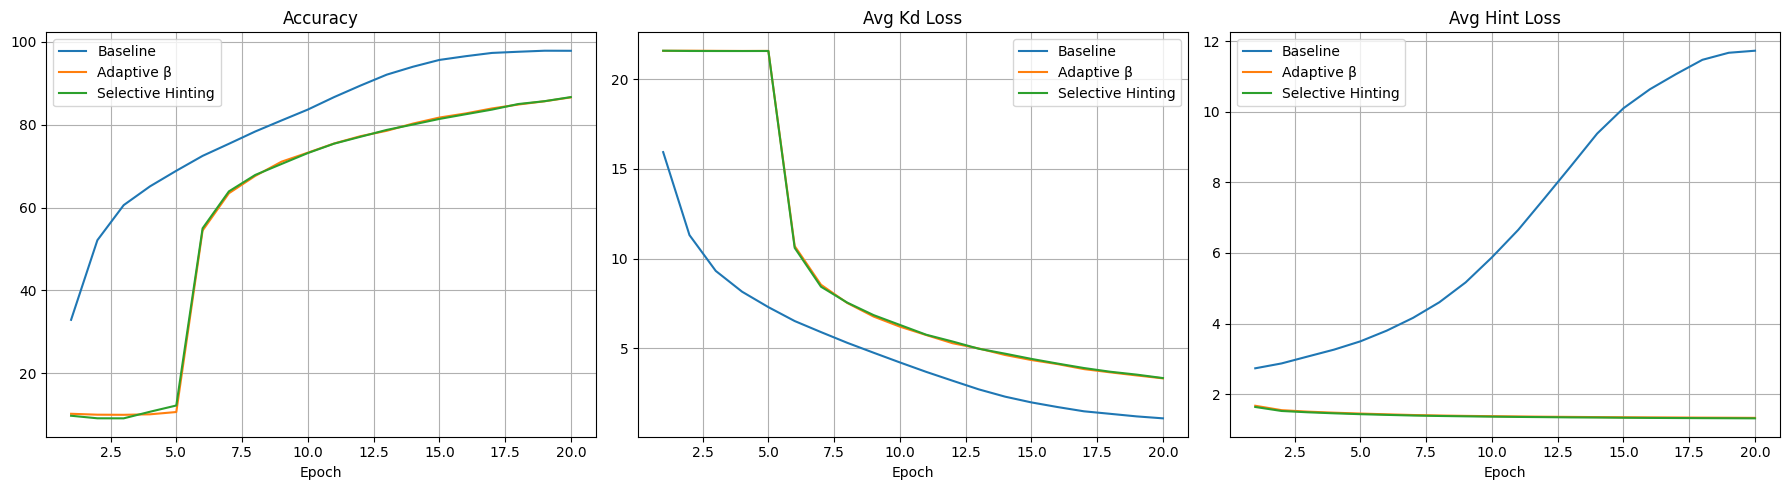

In [ ]:
def compare_experiments(histories, labels, colors=None):
    metrics = ["accuracy", "avg_kd_loss", "avg_hint_loss"]
    plt.figure(figsize=(18, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        for j, history in enumerate(histories):
            color = colors[j] if colors else None
            plt.plot(history['epoch'], history[metric], label=labels[j], color=color)
        plt.title(metric.replace('_', ' ').title())
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(drive_root, "comparison_plot.png"))
    plt.show()

compare_experiments(
    [history_baseline, history_adaptive, history_selective],
    labels=["Baseline", "Adaptive β", "Selective Hinting"]
)


In [ ]:
import numpy as np

def plot_summary_comparison(histories, labels):
    final_accs = [h['accuracy'].iloc[-1] for h in histories]
    final_kd   = [h['avg_kd_loss'].iloc[-1] for h in histories]
    final_hint = [h['avg_hint_loss'].iloc[-1] for h in histories]

    # --------- Bar Plot ---------
    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, final_accs, width, label='Accuracy (%)')
    plt.bar(x, final_kd, width, label='KD Loss')
    plt.bar(x + width, final_hint, width, label='Hint Loss')

    plt.xticks(x, labels)
    plt.ylabel('Final Epoch Metric Value')
    plt.title('Final Accuracy, KD Loss & Hint Loss Comparison')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(drive_root, 'final_metrics_bar.png'))
    plt.show()

    # --------- Radar Chart ---------
    def normalize(arr):
        arr = np.array(arr)
        return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

    metrics = ['Accuracy', 'KD Loss', 'Hint Loss']
    normalized_data = [
        normalize([final_accs[i], -final_kd[i], -final_hint[i]])  # invert loss metrics
        for i in range(len(histories))
    ]

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for i, row in enumerate(normalized_data):
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=labels[i])
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title("Normalized Final Performance (Higher is Better)")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig(os.path.join(drive_root, "radar_summary.png"))
    plt.show()


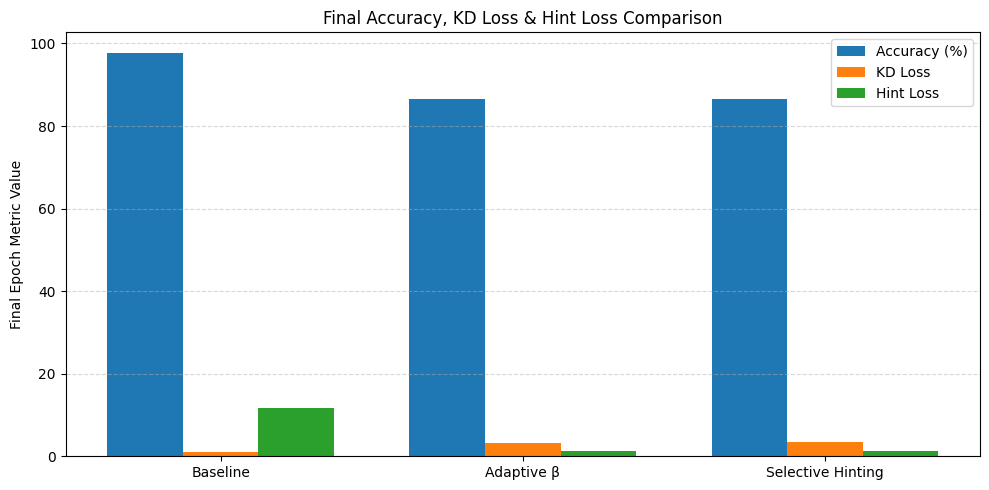

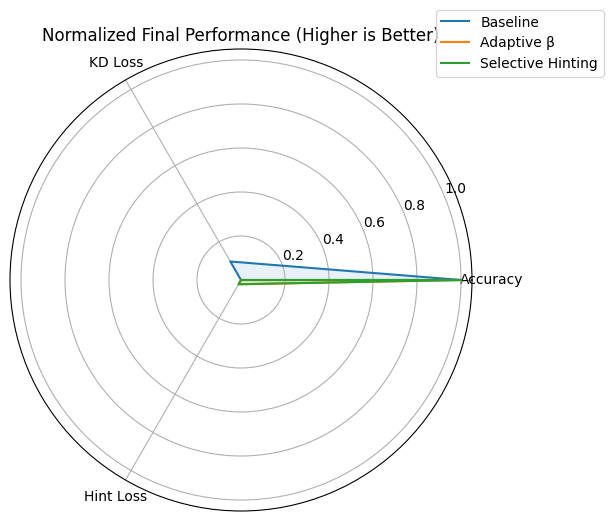

In [ ]:
plot_summary_comparison(
    [history_baseline, history_adaptive, history_selective],
    labels=["Baseline", "Adaptive β", "Selective Hinting"]
)
